## Task 2

forecasting_dataset.csv is a file that contains pollution data for a city. Your task is to create a model that, when fed with columns co_gt, nhmc, c6h6, s2, nox, s3, no2, s4, s5, t, rh, ah, and level, predicts the value of y six hours later.

In [124]:
# basic bitches
import numpy as np
import pandas as pd
import datetime as dt
import missingno as msn

# model
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Dropout
from sklearn.metrics import roc_curve, r2_score
from hpsklearn import HyperoptEstimator, any_classifier
from sklearn.linear_model import Ridge, Lasso, ElasticNet


# for pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import FunctionTransformer
from keras.wrappers.scikit_learn import KerasRegressor
# from src.task1.keras_model import keras_model
# from src.select_columns import select_columns

# viz
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from keras.callbacks import TensorBoard

# save model
from sklearn.externals import joblib

% matplotlib inline
rcParams['figure.figsize'] = 15, 6

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [2]:
df = pd.read_csv("../../data/forecasting_dataset.csv")
df.shape

(8421, 16)

In [3]:
df.head()

,date,time,y,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level
0,10/13/2004,20:00:00,943,-200.0,-200.0,7.2,867.0,-200.0,834.0,-200.0,1314.0,891.0,14.8,57.3,0.9603,NaN
1,8/10/2004,3:00:00,919,0.5,-200.0,3.9,704.0,-200.0,861.0,-200.0,1603.0,860.0,24.4,65.0,1.9612,Low
2,6/21/2004,8:00:00,1221,3.7,-200.0,23.3,1386.0,NaN,626.0,109.0,2138.0,NaN,23.3,38.6,1.0919,High
3,7/12/2004,12:00:00,1024,2.1,-200.0,12.1,1052.0,183.0,779.0,NaN,1690.0,952.0,28.5,27.3,1.0479,High
4,12/14/2004,12:00:00,1377,4.4,-200.0,21.7,1342.0,786.0,499.0,206.0,1546.0,2006.0,12.9,54.1,0.8003,High


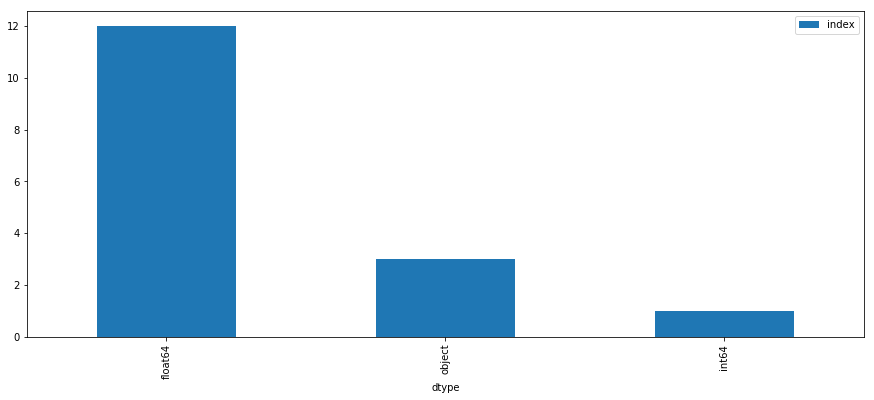

In [4]:
pd.DataFrame(df.dtypes.values, columns=['dtype']).reset_index().groupby('dtype').count().sort_values('index', ascending=False).plot(kind='bar')

### Explore missing value pattern

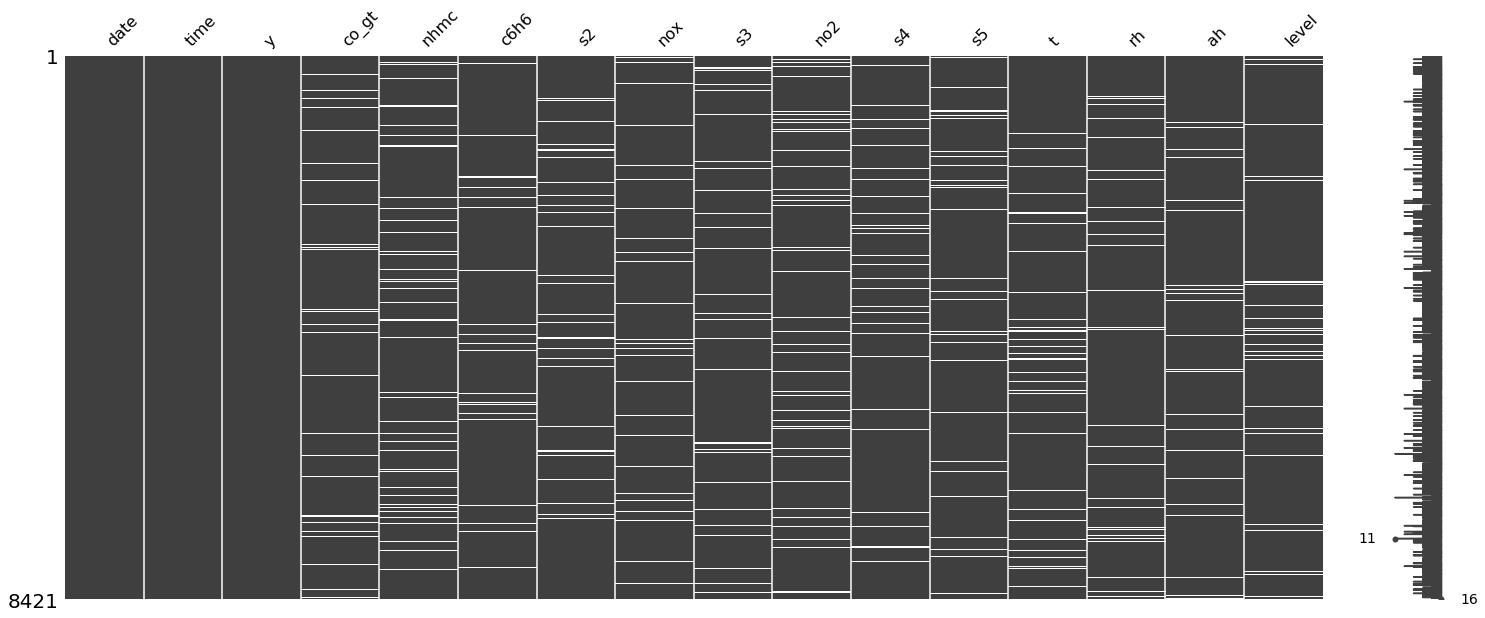

In [5]:
msn.matrix(df)

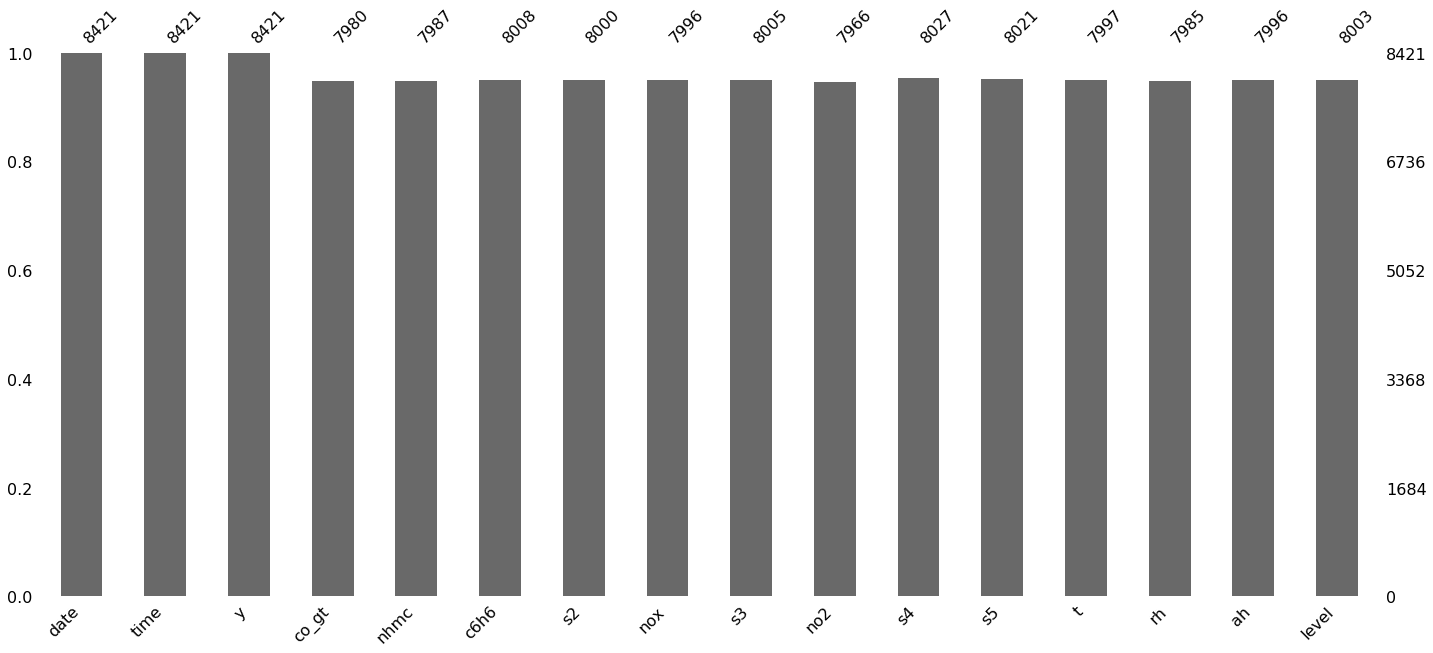

In [6]:
# Count number of value in each column
msn.bar(df)

## Explore time series problem

In [7]:
df['Datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df = df.sort_values('Datetime')
df = df.set_index('Datetime')

In [8]:
df.head()

,date,time,y,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level
Datetime,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,3/10/2004,18:00:00,1360,2.6,150.0,11.9,NaN,166.0,1056.0,113.0,1692.0,NaN,13.6,48.9,0.7578,High
2004-03-10 19:00:00,3/10/2004,19:00:00,1292,2.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,High
2004-03-10 20:00:00,3/10/2004,20:00:00,1402,2.2,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,NaN,0.7502,NaN
2004-03-10 21:00:00,3/10/2004,21:00:00,1376,2.2,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,High
2004-03-10 22:00:00,3/10/2004,22:00:00,1272,1.6,51.0,6.5,836.0,131.0,1205.0,116.0,NaN,1110.0,NaN,59.6,0.7888,High


In [9]:
df.tail()

,date,time,y,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level
Datetime,,,,,,,,,,,,,,,,
2005-02-24 10:00:00,2/24/2005,10:00:00,1178,2.7,-200.0,9.0,939.0,573.0,640.0,244.0,1228.0,NaN,4.1,83.9,0.6967,High
2005-02-24 11:00:00,2/24/2005,11:00:00,1093,1.8,NaN,6.5,836.0,414.0,728.0,232.0,1142.0,1025.0,NaN,82.0,0.6997,High
2005-02-24 12:00:00,2/24/2005,12:00:00,1060,1.4,-200.0,5.4,784.0,314.0,770.0,196.0,1117.0,941.0,5.5,79.5,0.7238,High
2005-02-24 13:00:00,2/24/2005,13:00:00,1121,1.7,-200.0,7.4,873.0,317.0,697.0,195.0,1206.0,1000.0,6.7,76.2,0.7519,High
2005-02-24 14:00:00,2/24/2005,14:00:00,1118,1.9,-200.0,NaN,888.0,290.0,685.0,189.0,1223.0,962.0,7.9,69.0,0.7394,High


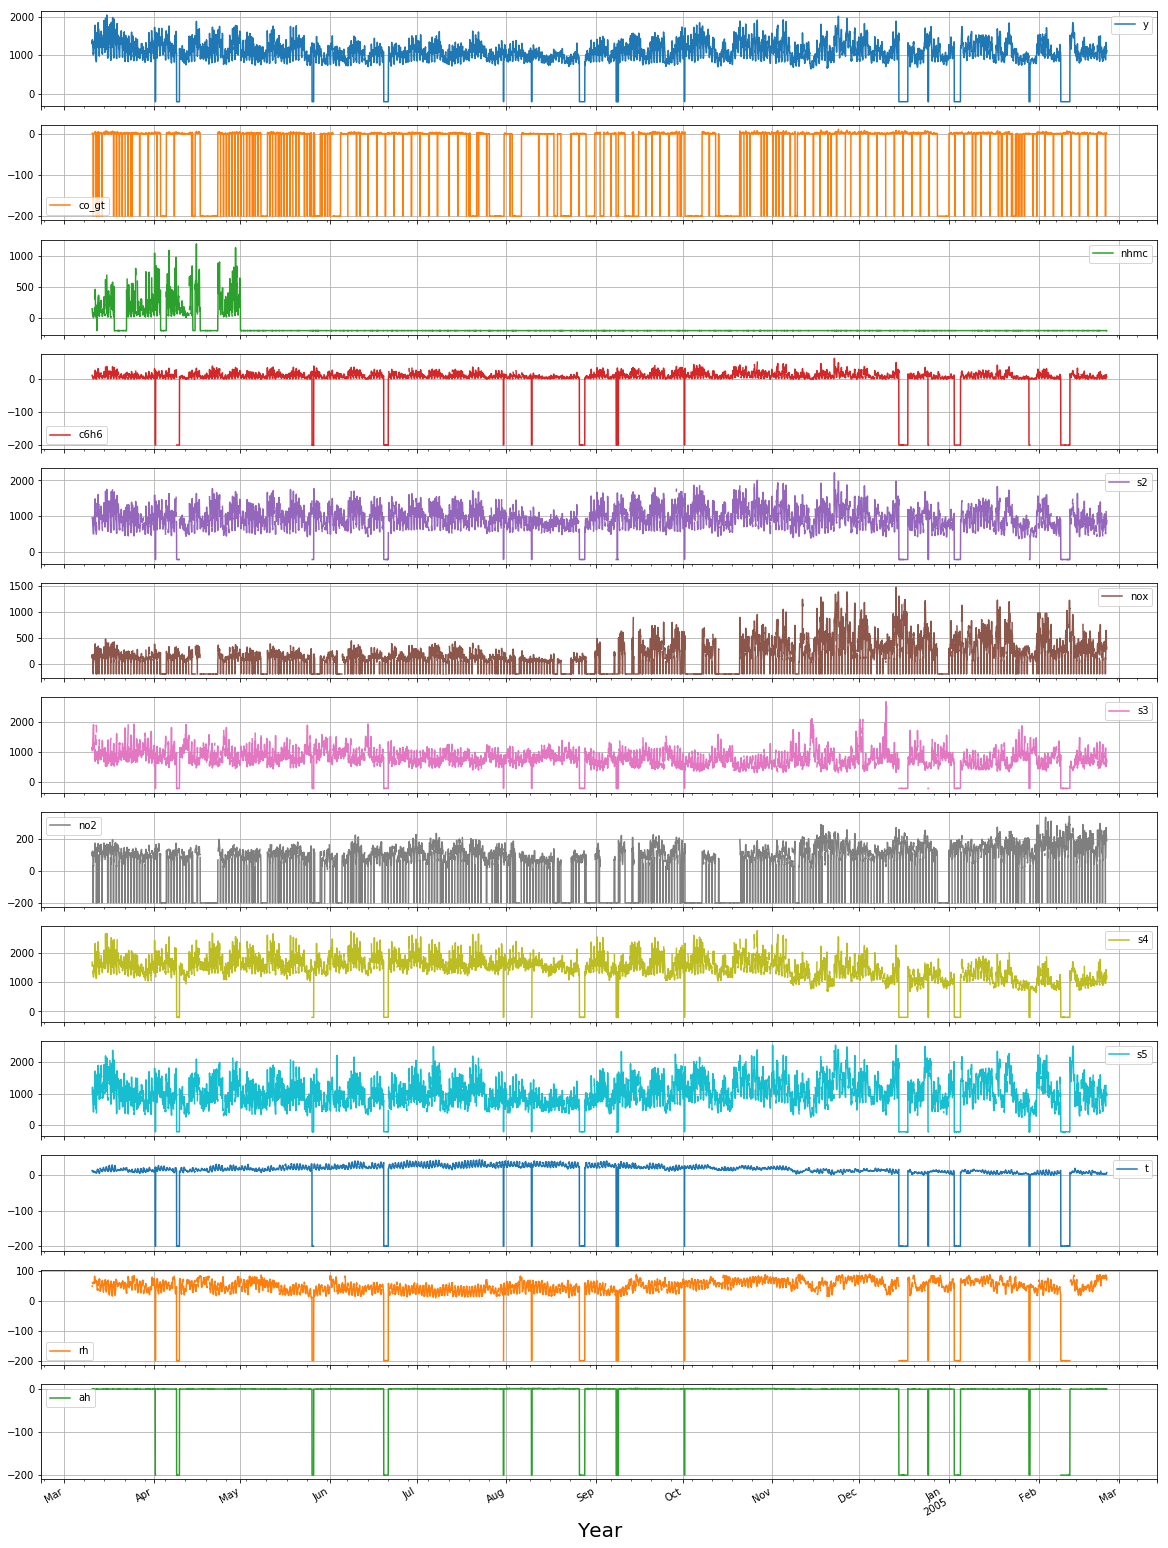

In [10]:
df.plot(figsize=(20,30), grid=True, subplots=True)
plt.xlabel('Year', fontsize=20);

Seems like most of the features

Identify trend by using rolling average

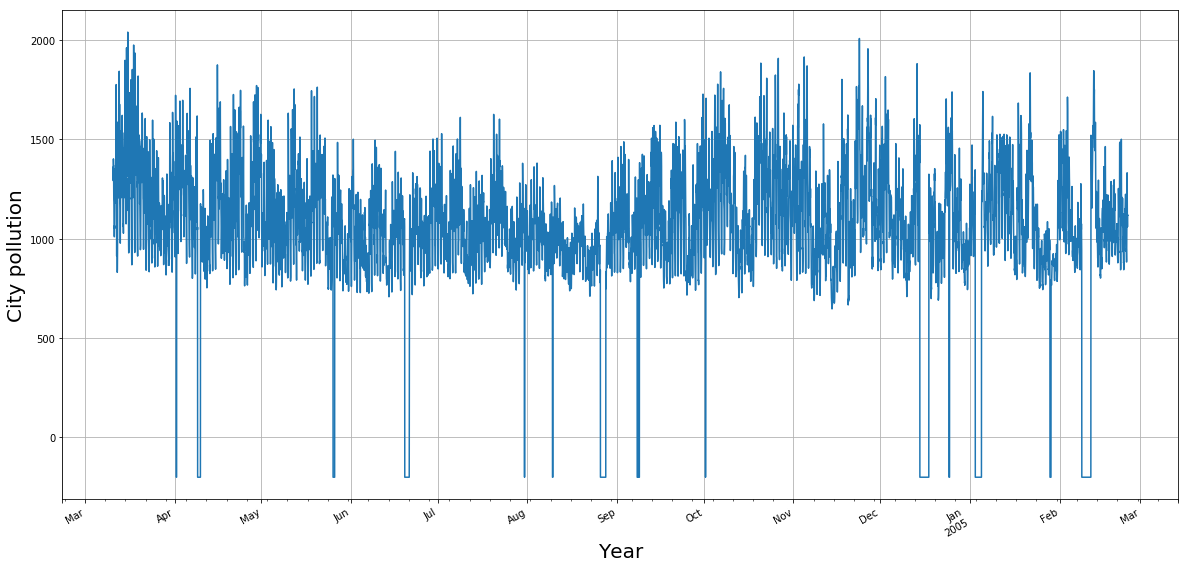

In [40]:
df['y'].plot(figsize=(20,10), grid=True, subplots=True)
plt.xlabel('Year', fontsize=20)
plt.ylabel('City pollution', fontsize=20);

In [11]:
df['y'].head(10)

Datetime
2004-03-10 18:00:00    1360
2004-03-10 19:00:00    1292
2004-03-10 20:00:00    1402
2004-03-10 21:00:00    1376
2004-03-10 22:00:00    1272
2004-03-10 23:00:00    1197
2004-03-11 00:00:00    1185
2004-03-11 01:00:00    1136
2004-03-11 02:00:00    1094
2004-03-11 03:00:00    1010
Name: y, dtype: int64

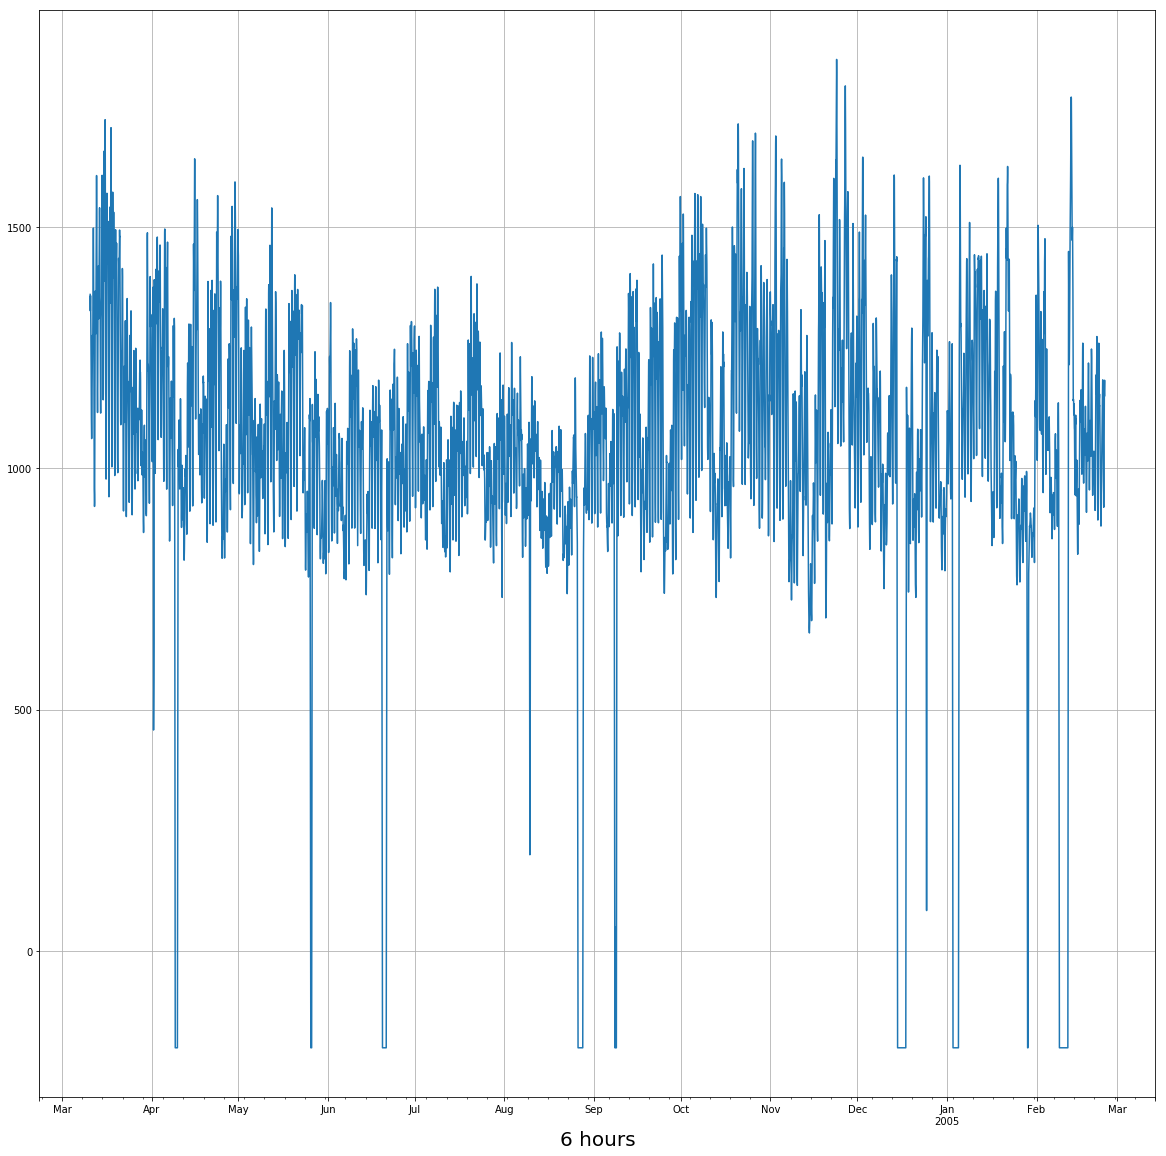

In [46]:
df['y'].rolling('6h').mean().plot(figsize=(20,20), fontsize=10, grid=True)
plt.xlabel('6 hours', fontsize=20);

In [13]:
# Time 
pollution = df.sort_values("y")

# Refactor the time_stamp column to datetime object
pollution["date"] = pd.to_datetime(df["date"])
pollution["time"] = pd.to_datetime(df["time"], format= '%H:%M:%S' ).dt.time

pollution = pollution.sort_values(["date","time"])

# Reset index
pollution = pollution.reset_index().iloc[:,1:29]
pollution.head()

,date,time,y,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level
0,2004-03-10,18:00:00,1360,2.6,150.0,11.9,NaN,166.0,1056.0,113.0,1692.0,NaN,13.6,48.9,0.7578,High
1,2004-03-10,19:00:00,1292,2.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,High
2,2004-03-10,20:00:00,1402,2.2,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,NaN,0.7502,NaN
3,2004-03-10,21:00:00,1376,2.2,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,High
4,2004-03-10,22:00:00,1272,1.6,51.0,6.5,836.0,131.0,1205.0,116.0,NaN,1110.0,NaN,59.6,0.7888,High


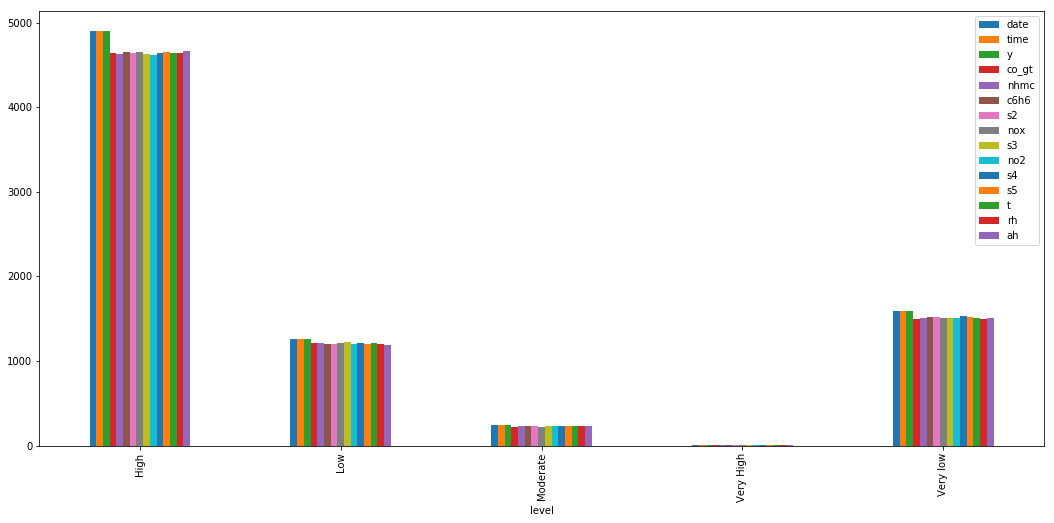

In [14]:
# Distribution of different levels of categorical variables:
fig, ax = plt.subplots(figsize=(18,8))
pollution.groupby('level').count().plot(kind='bar', ax=ax)

In [15]:
# Create column contains value of 6 hours later:
pollution["y_shift"] = pollution[['time','y']]['y'].transform(lambda g: g.shift(periods=-6))

In [16]:
pollution[['date','time','y',"y_shift"]].head()

,date,time,y,y_shift
0,2004-03-10,18:00:00,1360,1185.0
1,2004-03-10,19:00:00,1292,1136.0
2,2004-03-10,20:00:00,1402,1094.0
3,2004-03-10,21:00:00,1376,1010.0
4,2004-03-10,22:00:00,1272,1011.0


In [17]:
#Drop last 6 rows:
pollution.drop(pollution.tail(6).index,inplace=True)
pollution[['date','time','y',"y_shift"]].tail(10)

,date,time,y,y_shift
8405,2005-02-23,23:00:00,1016,883.0
8406,2005-02-24,00:00:00,1018,968.0
8407,2005-02-24,01:00:00,937,1071.0
8408,2005-02-24,02:00:00,949,1310.0
8409,2005-02-24,03:00:00,895,1332.0
8410,2005-02-24,04:00:00,884,1178.0
8411,2005-02-24,05:00:00,883,1093.0
8412,2005-02-24,06:00:00,968,1060.0
8413,2005-02-24,07:00:00,1071,1121.0
8414,2005-02-24,08:00:00,1310,1118.0


In [18]:
# Create a list of features needed
X_col = [ i for i in pollution.columns if i not in ['date', 'time', 'y_shift', 'y']]

In [19]:
# Create X, y
X = pollution[X_col]
y = pollution["y_shift"] # keeping time_stamp to split train test validation

In [20]:
# Split Train, Test, Validation set
total_obs = len(X['s2'])
thred = int(total_obs*0.1)
# For X
Xval = X[total_obs-thred:total_obs]
Xtest = X[total_obs-thred*2:total_obs-thred]
Xtrain = X[:total_obs-thred*2]

# For y:
yval = y[total_obs-thred:total_obs]
ytest = y[total_obs-thred*2:total_obs-thred]
ytrain = y[:total_obs-thred*2]

In [21]:
def select_columns(df, col_names):  # Tested [N]

    """
    Select only the columns that appears in the train set

    Args:
        df (dataframe): Test dataframe 
        col_names (list): List of all desired column names.

    Returns:
        df (dataframe): Original dataframe with only selected columns
    """
    
    # Test if all given column are in the dataframe:
    if set(col_names).issubset(list(df.columns.values)):  # Branch A
        df_new = df[col_names]
        
    else:  # Branch B
        new_col_names = [col for col in col_names if col in list(df.columns.values)]
        df_new = df[new_col_names]
    
    return df_new

### Trying Ridge

In [22]:
# Creating a pipeline:
pl = Pipeline([
        ('subset', FunctionTransformer(select_columns, kw_args={'col_names':X_col}, validate=False)),
        ('get_dummie', FunctionTransformer(pd.get_dummies, validate=False)),
        ('impute', Imputer(missing_values='NaN',
                            strategy="mean",
                            axis=0)),
        ('model', Ridge())
    ])

In [23]:
# Fitting the pipeline
pl.fit(Xtrain, ytrain)

Pipeline(memory=None,
     steps=[('subset', FunctionTransformer(accept_sparse=False,
          func=<function select_columns at 0x00000252997FF840>,
          inv_kw_args=None, inverse_func=None,
          kw_args={'col_names': ['co_gt', 'nhmc', 'c6h6', 's2', 'nox', 's3', 'no2', 's4', 's5', 't', 'rh', 'ah', 'level']},
      ...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [24]:
ypred = pl.predict(Xtest)

In [25]:
r2_score(ytest,ypred)

0.5222951215902017

In [60]:
# Fitting several models to find which one would be good:
model_list = {"Ridge Regression": Ridge(),
              "Lasso": Lasso(),
              "Elastic Net": ElasticNet(),
              "Support Vector Regression": SVR()
             }

for k, v in model_list.items():
    print("Fitting {} model...".format(k))
    pl = Pipeline([
        ('subset', FunctionTransformer(select_columns, kw_args={'col_names':X_col}, validate=False)),
        ('get_dummie', FunctionTransformer(pd.get_dummies, validate=False)),
        ('impute', Imputer(missing_values='NaN',
                            strategy="mean",
                            axis=0)),
        ('model', v)
    ])
    pl.fit(Xtrain, ytrain)
    ypred = pl.predict(Xtest)
    print("R squared score is:", r2_score(ytest,ypred).round(3))

Fitting Ridge Regression model...
R squared score is: 0.522
Fitting Lasso model...
R squared score is: 0.522
Fitting Elastic Net model...
R squared score is: 0.521
Fitting Support Vector Regression model...
R squared score is: -0.024


### Ordinary Least Square

In [120]:
# Import the statsmodels module
import statsmodels.api as sm

pl = Pipeline([
        ('subset', FunctionTransformer(select_columns, kw_args={'col_names':X_col}, validate=False)),
        ('get_dummie', FunctionTransformer(pd.get_dummies, validate=False)),
        ('impute', Imputer(missing_values='NaN',
                            strategy="mean",
                            axis=0))
    ])

Xtrain_new = pl.fit_transform(Xtrain)

# Fit the regression of y on x
result = sm.OLS(ytrain,Xtrain_new).fit()

# Print out the results 
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                y_shift   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     6876.
Date:                Mon, 23 Jul 2018   Prob (F-statistic):               0.00
Time:                        12:05:47   Log-Likelihood:                -46928.
No. Observations:                6733   AIC:                         9.389e+04
Df Residuals:                    6716   BIC:                         9.401e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3000      0.122     -2.467      0.0

In [121]:
Xtest_new = pl.fit_transform(Xtest)

ypred = result.predict(Xtest_new)

print("R squared score is:", r2_score(ytest,ypred).round(3))

R squared score is: 0.473


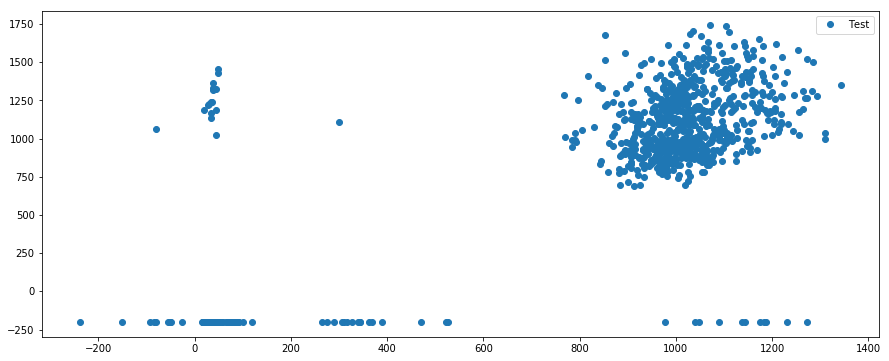

In [110]:
fig, ax = plt.subplots()
ax.plot(ypred, ytest, 'o', label="Test")
ax.legend(loc="best");

### Keras Neural Network

In [73]:
def keras_model(n_layers=2, n_feats=25, dropout_rate=0.2,
                loss="mean_squared_error"):  # Tested [N]
    """
    Creates and compiles a fully-connected feed forward neural network model using Keras

    Args:
        n_layers (int): Default=1. Number of hidden layers to include in the network.
        n_feats (int): Default=25. Number of features in the input data. Required to set input_shape
        dropout_rate (int): Default=0.2. Determines dropout rate for dropout layer.
        loss (str): Loss function to use when compiling the model.
                    Will be used by the optimizer during training to determine fit
        
    Returns:
        (keras.model) Compiled model containing the desired Dense layers.
                      After this, just needs to be fit with training/test data
    """
    
    model = Sequential()
    model.add(BatchNormalization())
    model.add(Dense(10, activation='relu', input_shape = (n_feats,)))
    
    for i in range(1, n_layers):  # Add each of the desired layers
        if i % 3 == 0:
            model.add(Dropout(dropout_rate))
        model.add(Dense(10, activation='relu'))
        
#     model.add(Dropout(dropout_rate))        
    
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', 
                  loss=loss, 
                  metrics=['accuracy'])

    return model

In [32]:
from time import time 
# Using TensorBoard to track on accuracy/ loss and each steps inside Keras model.
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [74]:
# Using pipeline with Keras model:
estimator = KerasRegressor(build_fn=keras_model, epochs=10, batch_size=5, verbose=1, callbacks=[tensorboard])

pl = Pipeline([
        ('subset', FunctionTransformer(select_columns, kw_args={'col_names':X_col}, validate=False)),
        ('get_dummie', FunctionTransformer(pd.get_dummies, validate=False)),    
        ('impute', Imputer(missing_values='NaN',
                            strategy="mean",
                            axis=0)), 
        ('model', estimator)
    ])
pl.fit(Xtrain, ytrain.values.reshape(-1,1))
ypred = pl.predict(Xtest)
print("R squared score is:", r2_score(ytest,ypred).round(3))

Epoch 1/10
6733/6733 [==============================] - 6s 911us/step - loss: 450792.7919 - acc: 7.4261e-04
Epoch 2/10
6733/6733 [==============================] - 6s 826us/step - loss: 90039.5455 - acc: 0.0015
Epoch 3/10
6733/6733 [==============================] - 6s 830us/step - loss: 80522.9401 - acc: 0.0013
Epoch 4/10
6733/6733 [==============================] - 6s 838us/step - loss: 76457.0172 - acc: 0.0024
Epoch 5/10
6733/6733 [==============================] - 6s 842us/step - loss: 73989.4465 - acc: 0.0019
Epoch 6/10
6733/6733 [==============================] - 6s 829us/step - loss: 72058.6017 - acc: 0.0021
Epoch 7/10
6733/6733 [==============================] - 6s 959us/step - loss: 71608.1345 - acc: 0.0015
Epoch 8/10
6733/6733 [==============================] - 6s 962us/step - loss: 72297.0712 - acc: 0.0018
Epoch 9/10
6733/6733 [==============================] - 7s 979us/step - loss: 72395.6528 - acc: 0.0016
Epoch 10/10
841/841 [==============================] - 1s 840us/step

### Conclusion
So the better model seems to be Ridge Regression. We will run this again with the whole training data and pickle the model.